# Antes de empezar asegurarse de tener librerias instaladas y tener el Kernel del VENV actual
### pip install numpy matplotlib scikit-learn opencv-python pillow ipython requests

# Procesamiento de Imágenes con Modelos de Color
## Ejercicio: Clasificación de Colores usando HSI y K-Means

Este cuaderno demuestra:
1. Fundamentos de color (Brillo, Matiz, Cromaticidad)
2. Conversiones entre modelos (RGB, CMY, YIQ, HSI, HSV)
3. Clasificación de colores con K-Means
4. Validación con imágenes aleatorias

# Importación de librerias generales

In [22]:
# Librerías estándar
import math

# Librerías científicas y numéricas
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Imágenes y procesamiento
import cv2
from PIL import Image

# Utilidades de entorno
from IPython.display import display, HTML

# Generalidades del sistema para procesamiento local
import os
import requests
from io import BytesIO



In [108]:
# Configurar matplotlib para visualización interactiva
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 1. CONVERSIONES DE MODELOS DE COLOR

In [109]:
def rgb_to_hsi(r, g, b):
    """
    Convierte RGB (0-255) a HSI
    
    Retorna: (H en grados [0-360], S [0-1], I [0-1])
    """
    # Normalizar a [0, 1]
    r_norm = r / 255.0
    g_norm = g / 255.0
    b_norm = b / 255.0
    
    # Intensidad
    I = (r_norm + g_norm + b_norm) / 3.0
    
    # Mínimo
    min_val = min(r_norm, g_norm, b_norm)
    
    # Saturación
    if I < 1e-6:
        S = 0
        H = 0
    else:
        S = 1 - (min_val / I)
        
        # Matiz
        if S < 1e-6:
            H = 0
        else:
            numerator = 0.5 * ((r_norm - g_norm) + (r_norm - b_norm))
            denominator = math.sqrt((r_norm - g_norm)**2 + (r_norm - b_norm)*(g_norm - b_norm))
            
            if denominator < 1e-6:
                H = 0
            else:
                cos_h = numerator / denominator
                cos_h = max(-1, min(1, cos_h))
                H = math.acos(cos_h) * 180 / math.pi
                
                if b_norm > g_norm:
                    H = 360 - H
    
    return H, S, I

def rgb_to_cmy(r, g, b):
    """Convierte RGB a CMY"""
    r_norm = r / 255.0
    g_norm = g / 255.0
    b_norm = b / 255.0
    return 1-r_norm, 1-g_norm, 1-b_norm

def rgb_to_yiq(r, g, b):
    """Convierte RGB a YIQ (estándar NTSC)"""
    r_norm = r / 255.0
    g_norm = g / 255.0
    b_norm = b / 255.0
    
    Y = 0.299*r_norm + 0.587*g_norm + 0.114*b_norm
    I = 0.596*r_norm - 0.275*g_norm - 0.321*b_norm
    Q = 0.212*r_norm - 0.523*g_norm + 0.311*b_norm
    
    return Y, I, Q

# Probar conversiones
print("PRUEBAS DE CONVERSIÓN RGB → HSI, CMY, YIQ")
print("=" * 70)

test_colors = [
    ("Rojo Puro", 255, 0, 0),
    ("Verde Puro", 0, 255, 0),
    ("Azul Puro", 0, 0, 255),
    ("Amarillo", 255, 255, 0),
    ("Naranja", 255, 165, 0),
    ("Gris", 128, 128, 128),
]

for name, r, g, b in test_colors:
    h, s, i = rgb_to_hsi(r, g, b)
    c, m, y = rgb_to_cmy(r, g, b)
    yq, iq, qq = rgb_to_yiq(r, g, b)
    
    print(f"\n{name:20} RGB({r:3},{g:3},{b:3})")
    print(f"  → HSI: H={h:6.1f}°, S={s:.3f}, I={i:.3f}")
    print(f"  → CMY: C={c:.3f}, M={m:.3f}, Y={y:.3f}")
    print(f"  → YIQ: Y={yq:.3f}, I={iq:.3f}, Q={qq:.3f}")

PRUEBAS DE CONVERSIÓN RGB → HSI, CMY, YIQ

Rojo Puro            RGB(255,  0,  0)
  → HSI: H=   0.0°, S=1.000, I=0.333
  → CMY: C=0.000, M=1.000, Y=1.000
  → YIQ: Y=0.299, I=0.596, Q=0.212

Verde Puro           RGB(  0,255,  0)
  → HSI: H= 120.0°, S=1.000, I=0.333
  → CMY: C=1.000, M=0.000, Y=1.000
  → YIQ: Y=0.587, I=-0.275, Q=-0.523

Azul Puro            RGB(  0,  0,255)
  → HSI: H= 240.0°, S=1.000, I=0.333
  → CMY: C=1.000, M=1.000, Y=0.000
  → YIQ: Y=0.114, I=-0.321, Q=0.311

Amarillo             RGB(255,255,  0)
  → HSI: H=  60.0°, S=1.000, I=0.667
  → CMY: C=0.000, M=0.000, Y=1.000
  → YIQ: Y=0.886, I=0.321, Q=-0.311

Naranja              RGB(255,165,  0)
  → HSI: H=  39.6°, S=1.000, I=0.549
  → CMY: C=0.000, M=0.353, Y=1.000
  → YIQ: Y=0.679, I=0.418, Q=-0.126

Gris                 RGB(128,128,128)
  → HSI: H=   0.0°, S=0.000, I=0.502
  → CMY: C=0.498, M=0.498, Y=0.498
  → YIQ: Y=0.502, I=-0.000, Q=-0.000


## 2. VISUALIZACIÓN DE COMPONENTES HSI

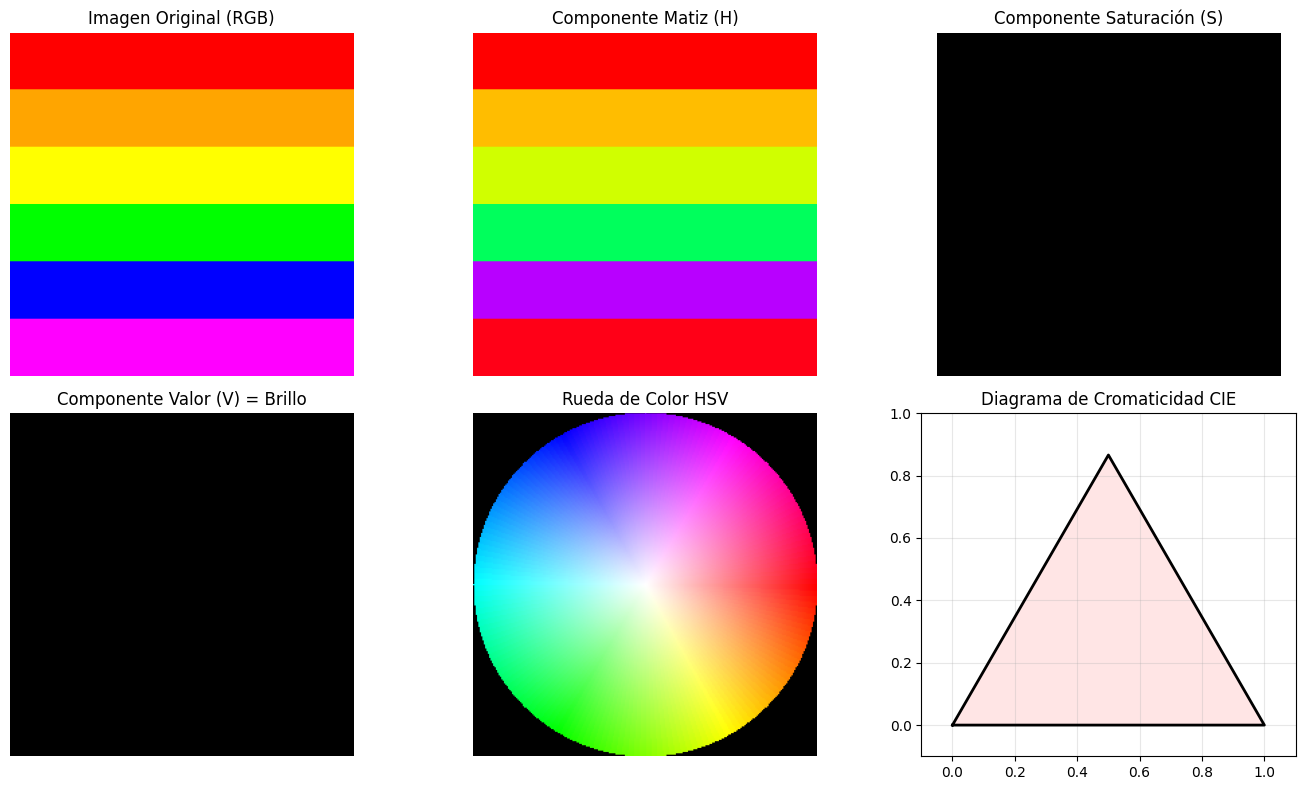

✓ Visualización de componentes HSI completada


In [110]:
# Crear imagen con colores primarios
width, height = 300, 300
image = np.zeros((height, width, 3), dtype=np.uint8)

# Dividir imagen en 6 secciones de colores
colors_rgb = [
    (255, 0, 0),      # Rojo
    (255, 165, 0),    # Naranja
    (255, 255, 0),    # Amarillo
    (0, 255, 0),      # Verde
    (0, 0, 255),      # Azul
    (255, 0, 255),    # Magenta
]

for idx, (r, g, b) in enumerate(colors_rgb):
    start_row = (idx * height) // 6
    end_row = ((idx + 1) * height) // 6
    image[start_row:end_row, :] = [b, g, r]  # OpenCV usa BGR

# Mostrar imagen original
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Imagen original (convertir BGR a RGB para matplotlib)
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Imagen Original (RGB)')
axes[0, 0].axis('off')

# Convertir a HSV para mostrar componentes (OpenCV usa HSV por disponibilidad)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
H = hsv_image[:,:,0].astype(np.float32) * 2  # OpenCV normaliza H a [0, 180]
S = hsv_image[:,:,1].astype(np.float32) / 255
V = hsv_image[:,:,2].astype(np.float32) / 255

# Mostrar componentes
axes[0, 1].imshow(H, cmap='hsv')
axes[0, 1].set_title('Componente Matiz (H)')
axes[0, 1].axis('off')

axes[0, 2].imshow(S, cmap='gray')
axes[0, 2].set_title('Componente Saturación (S)')
axes[0, 2].axis('off')

axes[1, 0].imshow(V, cmap='gray')
axes[1, 0].set_title('Componente Valor (V) = Brillo')
axes[1, 0].axis('off')

# Mostrar rueda de colores HSV
size = 256
wheel = np.zeros((size, size, 3), dtype=np.uint8)
for y in range(size):
    for x in range(size):
        dx = x - size/2
        dy = y - size/2
        r = math.sqrt(dx**2 + dy**2)
        angle = (math.atan2(dy, dx) * 180 / math.pi) % 360
        
        if r <= size/2:
            H_val = int(angle / 2)  # Normalizar a [0, 180] para OpenCV
            S_val = int(255 * min(r / (size/2), 1))
            V_val = 255
            wheel[y, x] = [H_val, S_val, V_val]

wheel_rgb = cv2.cvtColor(wheel, cv2.COLOR_HSV2BGR)
axes[1, 1].imshow(cv2.cvtColor(wheel_rgb, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Rueda de Color HSV')
axes[1, 1].axis('off')

# Mostrar diagrama de cromaticidad
axes[1, 2].plot([0, 1, 0.5, 0], [0, 0, math.sqrt(3)/2, 0], 'k-', linewidth=2)
axes[1, 2].fill([0, 1, 0.5], [0, 0, math.sqrt(3)/2], alpha=0.1, color='red')
axes[1, 2].set_title('Diagrama de Cromaticidad CIE')
axes[1, 2].set_xlim(-0.1, 1.1)
axes[1, 2].set_ylim(-0.1, 1)
axes[1, 2].set_aspect('equal')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualización de componentes HSI completada")

## 3. CLASIFICACIÓN DE COLORES

In [111]:
def classify_color_hsi(h, s, i):
    """
    Clasifica un color HSI en una categoría perceptual
    """
    if s < 0.1:
        return "GRIS"
    if h < 15 or h >= 345:
        return "ROJO"
    elif h >= 15 and h < 45:
        return "NARANJA"
    elif h >= 45 and h < 75:
        return "AMARILLO"
    elif h >= 75 and h < 165:
        return "VERDE"
    elif h >= 165 and h < 195:
        return "CYAN"
    elif h >= 195 and h < 255:
        return "AZUL"
    elif h >= 255 and h < 285:
        return "MAGENTA"
    else:
        return "DESCONOCIDO"

# Clasificar píxeles
print("\nCLASIFICACIÓN DE COLORES")
print("=" * 80)
print(f"{'Color':20} {'RGB':25} {'HSI':50} {'Categoría':15}")
print("-" * 80)

for name, r, g, b in test_colors:
    h, s, i = rgb_to_hsi(r, g, b)
    category = classify_color_hsi(h, s, i)
    print(f"{name:20} RGB({r:3},{g:3},{b:3})  HSI({h:6.1f}°,{s:.3f},{i:.3f})  {category:15}")


CLASIFICACIÓN DE COLORES
Color                RGB                       HSI                                                Categoría      
--------------------------------------------------------------------------------
Rojo Puro            RGB(255,  0,  0)  HSI(   0.0°,1.000,0.333)  ROJO           
Verde Puro           RGB(  0,255,  0)  HSI( 120.0°,1.000,0.333)  VERDE          
Azul Puro            RGB(  0,  0,255)  HSI( 240.0°,1.000,0.333)  AZUL           
Amarillo             RGB(255,255,  0)  HSI(  60.0°,1.000,0.667)  AMARILLO       
Naranja              RGB(255,165,  0)  HSI(  39.6°,1.000,0.549)  NARANJA        
Gris                 RGB(128,128,128)  HSI(   0.0°,0.000,0.502)  GRIS           


## 4. ANÁLISIS DE PSEUDOCOLOR

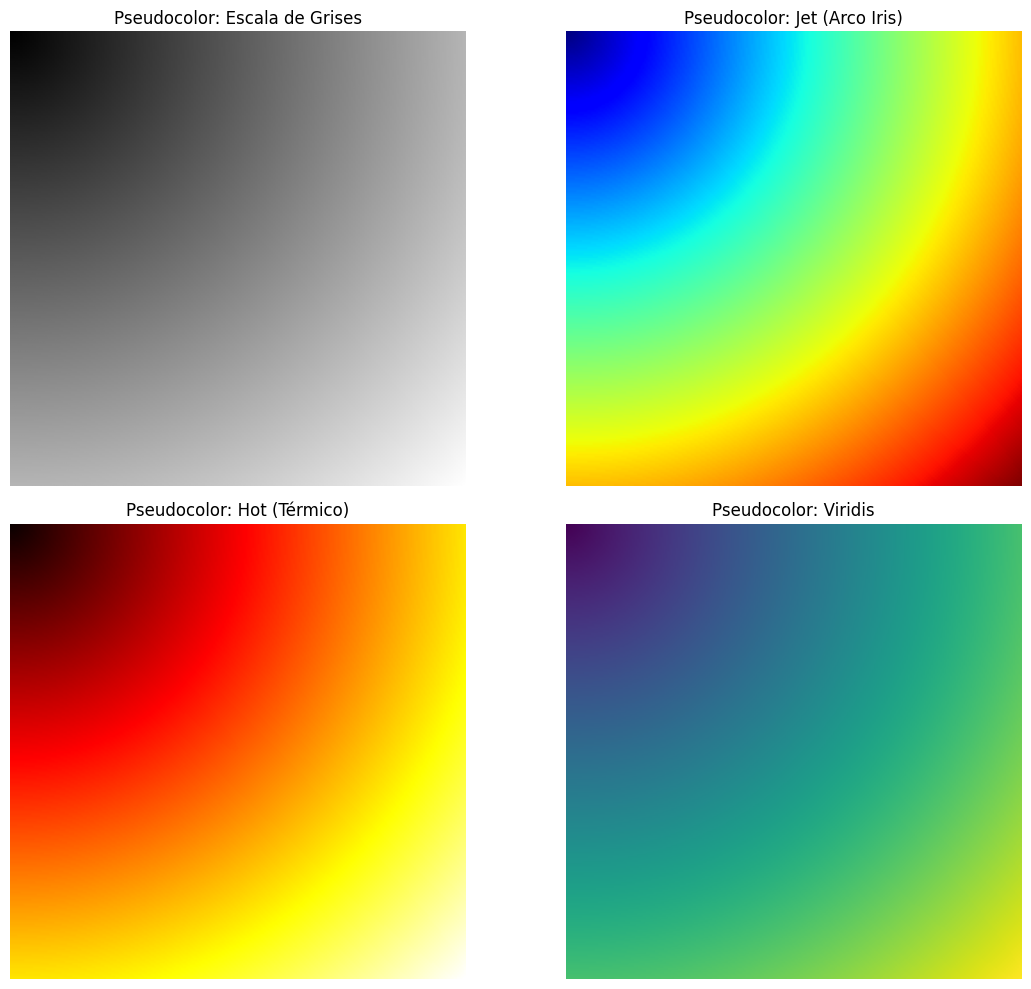

✓ Análisis de pseudocolor completado


In [112]:
# Crear una imagen de gradiente (simular datos escalares)
gradient = np.zeros((256, 256), dtype=np.float32)
for i in range(256):
    for j in range(256):
        gradient[i, j] = math.sqrt(i**2 + j**2) / (256 * math.sqrt(2))

# Aplicar diferentes mapas de pseudocolor
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Escala de grises
axes[0, 0].imshow(gradient, cmap='gray')
axes[0, 0].set_title('Pseudocolor: Escala de Grises')
axes[0, 0].axis('off')

# Mapa "Jet" (arco iris)
axes[0, 1].imshow(gradient, cmap='jet')
axes[0, 1].set_title('Pseudocolor: Jet (Arco Iris)')
axes[0, 1].axis('off')

# Mapa "Hot" (negro-rojo-amarillo)
axes[1, 0].imshow(gradient, cmap='hot')
axes[1, 0].set_title('Pseudocolor: Hot (Térmico)')
axes[1, 0].axis('off')

# Mapa "Viridis"
axes[1, 1].imshow(gradient, cmap='viridis')
axes[1, 1].set_title('Pseudocolor: Viridis')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Análisis de pseudocolor completado")

## 5. COMPARACIÓN HSI vs HSV

In [113]:
print("\nCOMPARACIÓN HSI vs HSV")
print("=" * 80)
print(f"{'Característica':30} {'HSI':25} {'HSV':25}")
print("-" * 80)
print(f"{'Geometría':30} {'Doble cono':25} {'Cono simple':25}")
print(f"{'Valor máximo':30} {'I=1 (centro blanco)':25} {'V=1 (punta)':25}")
print(f"{'Saturación S=0':30} {'Eje gris':25} {'Eje gris':25}")
print(f"{'Saturación S=1':30} {'Color puro':25} {'Color puro':25}")
print(f"{'Separación componentes':30} {'I desacoplada':25} {'V acoplada a S':25}")
print(f"{'Aplicación principal':30} {'Visión artificial':25} {'UI interactiva':25}")
print(f"{'Complejidad conversión':30} {'Moderada':25} {'Simple':25}")


COMPARACIÓN HSI vs HSV
Característica                 HSI                       HSV                      
--------------------------------------------------------------------------------
Geometría                      Doble cono                Cono simple              
Valor máximo                   I=1 (centro blanco)       V=1 (punta)              
Saturación S=0                 Eje gris                  Eje gris                 
Saturación S=1                 Color puro                Color puro               
Separación componentes         I desacoplada             V acoplada a S           
Aplicación principal           Visión artificial         UI interactiva           
Complejidad conversión         Moderada                  Simple                   


## 6. VALIDACIÓN ALEATORIA

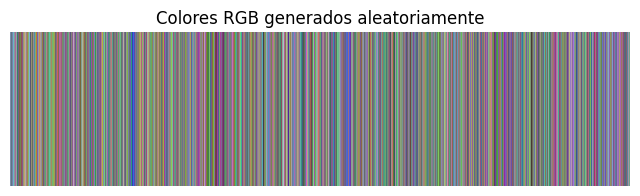

In [115]:
# Generar n colores RGB aleatorios
n = 2500
np.random.seed(4882)
colors_rgb = np.random.randint(0, 256, size=(n, 3))

# Visualización rápida de los colores
plt.figure(figsize=(8, 2))
plt.imshow([colors_rgb / 255.0], aspect='auto')
plt.axis('off')
plt.title("Colores RGB generados aleatoriamente")
plt.show()


# 7. OBTENER CENTROIDES CON EL METODO DEL CODO

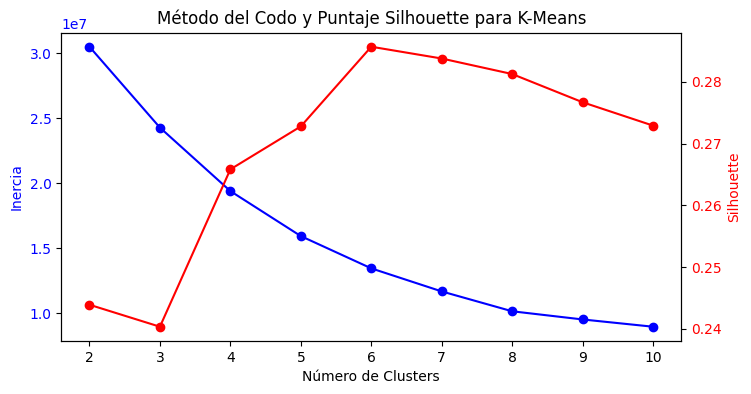

In [131]:
inertias = []
silhouettes = []
K_values = range(2, 11)  # de 2 a 10 clusters

# Evaluar diferentes valores de K
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(colors_rgb)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(colors_rgb, kmeans.labels_))

# Determinar el mejor K según el puntaje Silhouette
best_k = K_values[np.argmax(silhouettes)]
best_score = max(silhouettes)

# Graficar método del codo y Silhouette
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(K_values, inertias, 'bo-', label='Inercia (Codo)')
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(K_values, silhouettes, 'ro-', label='Puntaje Silhouette')
ax2.set_ylabel('Silhouette', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Método del Codo y Puntaje Silhouette para K-Means")
plt.show()

# Entrenar K-Means con el mejor número de clusters
k_opt = best_k
#k_opt = 20
kmeans = KMeans(n_clusters=k_opt, random_state=42)
kmeans.fit(colors_rgb)
centroids = kmeans.cluster_centers_.astype(int)
labels = kmeans.labels_

# 8. DEMOSTRACIÓN CON COLORES DE CENTROIDES

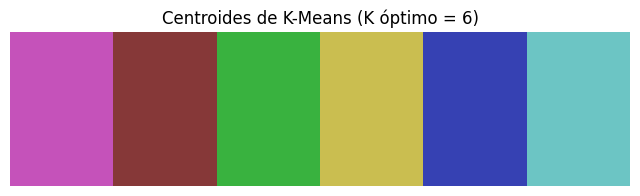

In [128]:
# Visualizar los colores centroides
plt.figure(figsize=(8, 2))
plt.imshow([centroids / 255.0], aspect='auto')
plt.axis('off')
plt.title(f"Centroides de K-Means (K óptimo = {k_opt})")
plt.show()

# 9. GRAFICO 3D DE CLUSTERIZACION PARA RGB

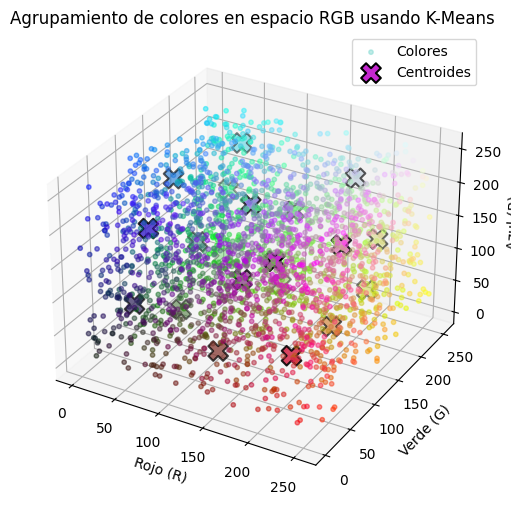

In [122]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    colors_rgb[:, 0], colors_rgb[:, 1], colors_rgb[:, 2],
    c=np.array(colors_rgb)/255.0, s=10, alpha=0.5, label='Colores'
)
ax.scatter(
    centroids[:, 0], centroids[:, 1], centroids[:, 2],
    c=centroids/255.0, s=200, marker='X', edgecolors='black', linewidths=1.5, label='Centroides'
)

ax.set_xlabel("Rojo (R)")
ax.set_ylabel("Verde (G)")
ax.set_zlabel("Azul (B)")
ax.set_title("Agrupamiento de colores en espacio RGB usando K-Means")
ax.legend()
plt.show()


# 10. Predicción: Dado un nuevo color, determinar su grupo ideal

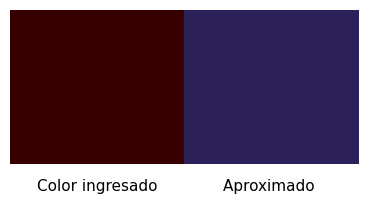

In [125]:
nuevo_color = np.array([[55, 0, 0]]) 

cluster_pred = kmeans.predict(nuevo_color)[0]
color_ideal = centroids[cluster_pred].astype(int)

# Mostrar resultado descriptivo
display(HTML(f"""
<div style="font-family:sans-serif; font-size:16px; line-height:1.6;">
<b>Cluster asignado:</b> {cluster_pred}<br>
</div>
"""))

# Comparación visual
fig, ax = plt.subplots(figsize=(4.5, 2))
ax.axis("off")

ax.add_patch(patches.Rectangle((0, 0), 0.5, 1, color=nuevo_color[0] / 255.0))
ax.add_patch(patches.Rectangle((0.5, 0), 0.5, 1, color=color_ideal / 255.0))
ax.text(0.25, -0.1, "Color ingresado", ha="center", va="top", fontsize=11)
ax.text(0.75, -0.1, f"Aproximado ", ha="center", va="top", fontsize=11)
plt.show()


## 11. CONCLUSIONES

### Conceptos Clave Demostrados:

**1. Brillo**: Representado por I en HSI, V en HSV, Y en YIQ
- Define intensidad luminosa independientemente del color

**2. Matiz (Hue)**: Ángulo en [0°, 360°]
- 0° = Rojo, 120° = Verde, 240° = Azul
- Separado de luminancia en HSI/HSV/YIQ

**3. Cromaticidad**: Combinación de H y S
- Describe "tipo" de color sin brillo
- Fundamental para procesamiento de imagen

**4. Modelos de Color**:
- **RGB**: Aditivo, dispositivos con luz
- **CMY**: Sustractivo, impresoras
- **YIQ**: Compatibilidad TV analógica
- **HSI**: Percepción humana, visión artificial
- **HSV**: Interfaz usuario, selector de colores

# Alojamiento de Imagenes para prueba de K-Means

In [23]:
# Crear carpeta si no existe
os.makedirs('dataset_jpg', exist_ok=True)

url_random = "https://minimalistic-wallpaper.demolab.com/?random"

for i in range(1, 6):
    try:
        # Solicitar la imagen (seguirá redirecciones)
        response = requests.get(url_random, allow_redirects=True, timeout=10)
        response.raise_for_status()

        # Abrir la imagen desde bytes y guardar como JPG
        img = Image.open(BytesIO(response.content))
        img = img.convert("RGB")  # asegurar formato RGB
        img.save(f"dataset_jpg/wallpaper_{i}.jpg", "JPEG")
    except Exception as e:
        # Si hay error, intentar nuevamente con el siguiente índice
        print(f"No se pudo guardar la imagen {i}: {e}")